# Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import *

import pandas as pd
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import Dense, Activation, Dropout, Flatten

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

In [2]:
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization
from keras import backend as K

In [3]:
import os
import PIL
import PIL.Image
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tqdm import tqdm
import cv2
import pathlib

# Load Dataset 

In [4]:
dataset = '../input/fer2013/fer2013.csv'

# This dataset consists of 35887 grayscale, 48x48 sized face images with 7 labeled emotions

labels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
names=['emotion','pixels','usage']
df=pd.read_csv(dataset,names=names, na_filter=False)
images=df['pixels']
df.head(10)

,emotion,pixels,usage
0,emotion,pixels,Usage
1,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
2,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
4,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
5,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
7,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
8,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
9,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training


In [5]:
def getData(filname):
    # images are 48x48
    # N = 35887
    Y = []
    X = []
    first = True
    for line in open(filname):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X = np.array(X)
    Y = np.array(Y)
    return X, Y

In [6]:
X, Y = getData(dataset)

#Normalization
X = X/255

num_class = len(set(Y))
print(num_class)

7


In [7]:
N, D = X.shape
img_X = X.reshape(N, 48, 48)

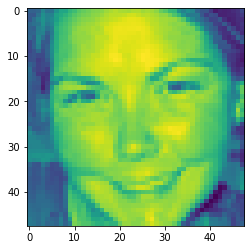

In [8]:
imgplot = plt.imshow(img_X[8])

# Training Model

In [9]:
X = X.reshape(N, 48, 48, 1)

In [10]:
Y = (np.arange(num_class) == Y[:, None]).astype(np.float32)

In [11]:
def my_model():
    model = Sequential()
    input_shape = (48,48,1)
    model.add(Conv2D(64, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(7))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    
    return model
model=my_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       409728    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

In [12]:
path_model='model_filter.h5' # save model at this location after each epoch
tf.keras.backend.clear_session() # destroys the current graph and builds a new one

model=my_model() # create the model
K.set_value(model.optimizer.lr,1e-3) # set the learning rate

# fit the model
h=model.fit(x=X,     
            y=Y,
            validation_split = 0.2,
            batch_size=64, 
            epochs=20, 
            verbose=1,
            shuffle=True,
            callbacks=[ModelCheckpoint(filepath=path_model),]
            )

Epoch 1/20
449/449 [==============================] - 10s 23ms/step - loss: 1.7112 - accuracy: 0.3323 - val_loss: 1.8987 - val_accuracy: 0.2902
Epoch 2/20
449/449 [==============================] - 10s 22ms/step - loss: 1.3529 - accuracy: 0.4818 - val_loss: 1.4350 - val_accuracy: 0.4689
Epoch 3/20
449/449 [==============================] - 10s 23ms/step - loss: 1.1509 - accuracy: 0.5646 - val_loss: 1.1729 - val_accuracy: 0.5584
Epoch 4/20
449/449 [==============================] - 10s 23ms/step - loss: 1.0199 - accuracy: 0.6205 - val_loss: 1.1857 - val_accuracy: 0.5472
Epoch 5/20
449/449 [==============================] - 10s 22ms/step - loss: 0.8960 - accuracy: 0.6687 - val_loss: 1.1540 - val_accuracy: 0.5678
Epoch 6/20
449/449 [==============================] - 10s 23ms/step - loss: 0.7573 - accuracy: 0.7207 - val_loss: 1.1572 - val_accuracy: 0.5848
Epoch 7/20
449/449 [==============================] - 10s 22ms/step - loss: 0.5911 - accuracy: 0.7858 - val_loss: 1.2238 - val_accuracy:

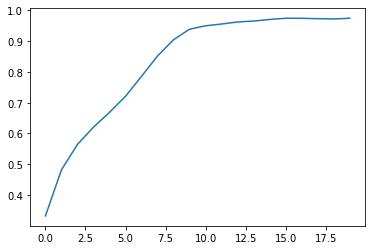

In [13]:
plt.plot(h.history['accuracy'])

# Prediction

In [14]:
objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
y_pos = np.arange(len(objects))
print(y_pos)

[0 1 2 3 4 5 6]


In [15]:
def emotion_analysis(emotions):
    objects = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, emotions, align='center', alpha=0.9)
    plt.tick_params(axis='x', which='both', pad=10,width=4,length=10)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
plt.show()

In [16]:
from skimage import io


def predict_emotion(path):
    img = image.load_img(path, grayscale=True, target_size=(48, 48))
    show_img=image.load_img(path, grayscale=False, target_size=(200, 200))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)

    x /= 255

    custom = model.predict(x)
    emotion_analysis(custom[0])

    x = np.array(x, 'float32')
    x = x.reshape([48, 48]);

    plt.gray()
    plt.imshow(show_img)
    plt.show()

    m=0.000000000000000000001
    a=custom[0]
    for i in range(0,len(a)):
        if a[i]>m:
            m=a[i]
            ind=i
        
    print('Expression Prediction:',objects[ind])

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


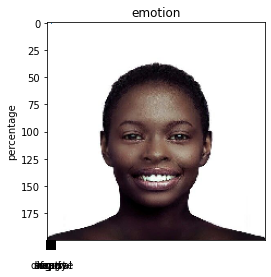

Expression Prediction: happy


In [17]:
predict_emotion('../input/images/h_image.jpg')

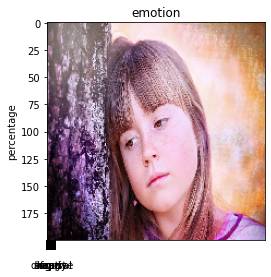

Expression Prediction: surprise


In [18]:
predict_emotion('../input/images/s_image.jpg')